In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pingouin as pg

#df_anno = pd.read_feather("anno.feather")
df_V1 = pd.read_csv("./Human_Cortical/V1/CrossAreal_V1_RSC-122-359_ann_map_full_QC.csv")
df_M1 = pd.read_csv("./Human_Cortical/M1/CrossAreal_M1_RSC-122-359_ann_map_full_QC.csv")
df_DLPFC = pd.read_csv("./Human_Cortical/DLPFC/CrossAreal_DLPFC_RSC-122-359_ann_map_full_QC.csv")
df_MTG = pd.read_csv("./Human_Cortical/MTG/CrossAreal_MTG_RSC-122-359_ann_map_full_QC.csv")


/var/folders/vj/7bfz8tc91053qf1swtym13nc0000gp/T/ipykernel_75607/1930722306.py:8: DtypeWarning: Columns (41,126,140,151) have mixed types. Specify dtype option on import or set low_memory=False.
  df_V1 = pd.read_csv("./Human_Cortical/V1/CrossAreal_V1_RSC-122-359_ann_map_full_QC.csv")
/var/folders/vj/7bfz8tc91053qf1swtym13nc0000gp/T/ipykernel_75607/1930722306.py:9: DtypeWarning: Columns (41,126,140,151) have mixed types. Specify dtype option on import or set low_memory=False.
  df_M1 = pd.read_csv("./Human_Cortical/M1/CrossAreal_M1_RSC-122-359_ann_map_full_QC.csv")
/var/folders/vj/7bfz8tc91053qf1swtym13nc0000gp/T/ipykernel_75607/1930722306.py:10: DtypeWarning: Columns (41,126,140,151) have mixed types. Specify dtype option on import or set low_memory=False.
  df_DLPFC = pd.read_csv("./Human_Cortical/DLPFC/CrossAreal_DLPFC_RSC-122-359_ann_map_full_QC.csv")
/Users/xiaoping.liu/anaconda3/envs/patch-seq/lib/python3.8/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package p

In [2]:
df_V1.shape

(7097, 179)

In [3]:
#df_V1 = df_V1[[roi in ["OCx","VISp"] for roi in df_V1.roi]]
# Overwrites Region column
df_V1 = df_V1[df_V1['roi'].str.contains('OCx|VISp').fillna(False)]
df_V1['Region'] = 'Occipital'
df_V1.shape

(389, 180)

In [4]:
df_MTG = df_MTG[df_MTG['roi'].str.contains('TCx|Tcx|TEa').fillna(False)]
df_MTG['Region'] = 'Temporal'

In [5]:
df_M1_FCx = df_M1[df_M1['roi'].str.contains('FCx').fillna(False)]
df_M1 = df_M1[df_M1['roi'].str.contains('MOp').fillna(False)]
df_M1['Region'] = 'Frontal'

In [6]:
df_DLPFC_FCx = df_DLPFC[df_DLPFC['roi'].str.contains('FCx').fillna(False)]
df_DLPFC = df_DLPFC[df_DLPFC['roi'].str.contains('dlPFC').fillna(False)]
df_DLPFC['Region'] = 'Frontal'

In [7]:
# Find cells that map the same in df_M1 and df_DLPFC atlases, change label to FCx
# Because Tree mapping confusions are much more sensible, we will use Tree mapping results

df_FCx = df_M1_FCx[df_M1_FCx['CrossArea_cluster_Tree'] == df_DLPFC_FCx['CrossArea_cluster_Tree']]
df_FCx['Region'] = 'Frontal'

print(df_FCx.shape)   # Lost a lot of samples

(290, 180)


/var/folders/vj/7bfz8tc91053qf1swtym13nc0000gp/T/ipykernel_75607/813057833.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_FCx['roi_coarse'] = 'Frontal'


In [9]:
# Join with MTG, V1, M1
df_main = pd.concat([df_V1, df_MTG, df_M1, df_DLPFC, df_FCx], axis=0, join='outer')
print(df_main.shape)

(4715, 180)


In [10]:
df_id = pd.read_csv("./custom_report.csv")
df2 = pd.merge(df_main, df_id, how='inner', left_on='cell_name', right_on='cell_specimen_name ', sort=True)
df2.shape

(2610, 248)

In [11]:
# Merge with features sheet
df_ephys = pd.read_csv("./ephys_features_20240426.csv")
df_ephys.columns
df3 = pd.merge(df2, df_ephys, how='inner', left_on='cell_specimen_id ', right_on='cell_name', sort=True)
print(df3.shape)
df3['CrossArea_subclass_Tree'].value_counts()

(2608, 361)


L4 IT         413
Sst           410
Pvalb         370
L2/3 IT       343
L6 CT         180
Lamp5         160
Sncg          159
Vip           124
Pax6           98
L5/6 NP        61
L6b            58
Chandelier     53
L5 IT          44
L6 IT          44
Lamp5 Lhx6     34
Sst Chodl      24
L6 IT Car3     22
L5 ET          11
Name: CrossArea_subclass_Tree, dtype: int64

In [12]:
# QC filter joined list

df3_filt = df3[df3['percent_reads_aligned_total']>=25]    # was 50%
print(len(df3_filt))
df3_filt = df3_filt[df3_filt['Genes.Detected']>=1000]
print(len(df3_filt))
#df3_filt = df3_filt[df3_filt['score.Corr']>=0.55]
df3_filt = df3_filt[df3_filt['marker_sum_norm_label'] >= 0.6]
print(len(df3_filt))
#df3_filt = df3_filt[df3_filt['rna_amplification_pass_fail_label']=='Pass']
print(len(df3_filt))
# Layer labels have no numerics, no need to filter
df3_filt['CrossArea_subclass_Tree'].value_counts()

2589
2506
1696
1696


L4 IT         376
L2/3 IT       303
Pvalb         257
Sst           220
Lamp5         103
Sncg           95
Vip            76
Pax6           59
L6 CT          42
L5/6 NP        33
L6 IT          31
L5 IT          30
Lamp5 Lhx6     24
L6b            17
Chandelier     13
L6 IT Car3     11
Sst Chodl       5
L5 ET           1
Name: CrossArea_subclass_Tree, dtype: int64

In [13]:
# Subset to L4 IT and L2/3 IT
df4 = df3_filt[[sc in ['L4 IT', 'L2/3 IT'] for sc in df3_filt['CrossArea_subclass_Tree']]]
df4.shape

(679, 361)

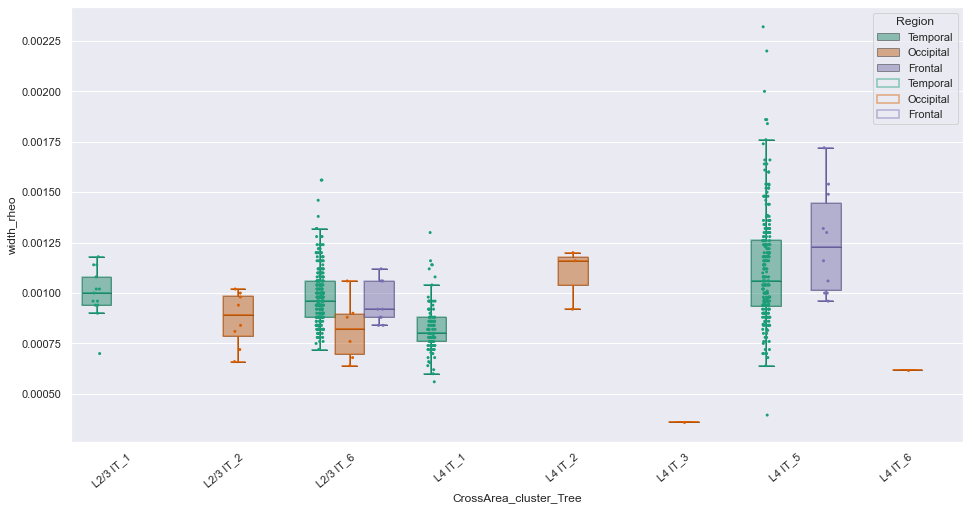

In [53]:
# plot by cluster and roi

def plot_property (df, feature, feat_name, ax):
    order = ['L2/3 IT_1','L2/3 IT_2','L2/3 IT_3','L2/3 IT_4','L2/3 IT_5','L2/3 IT_6','L4 IT_1','L4 IT_2','L4 IT_3','L4 IT_4','L4 IT_5', 'L4 IT_6']
    order = [cat for cat in order if df["CrossArea_cluster_Tree"].str.contains(cat).any()]
    plt.axes(ax)
    sns.boxplot(x="CrossArea_cluster_Tree", y=feature, hue="Region", palette="Dark2", 
                 order=order, showfliers=False, boxprops=dict(alpha=.5), data=df)  
    sns.stripplot(x="CrossArea_cluster_Tree", y=feature, hue="Region", palette="Dark2", 
                 order=order, data=df4, ax=ax, dodge=True, legend = False, size=3)
    sns.boxplot(x="CrossArea_cluster_Tree", y=feature, hue="Region", palette="Dark2", 
                 order=order, showfliers=False, fill = False, color = 'k', boxprops=dict(alpha=.5), data=df)  
    #ax.set_xticklabels(ax.get_xticklabels(),rotation=40)
    plt.xticks(rotation = 40, ha='right', rotation_mode='anchor')
    # adding transparency to colors
    for patch in ax.artists:
        r, g, b, a = patch.get_facecolor()
        patch.set_facecolor((r, g, b, .3))
    plt.show()

fig, ax1 = plt.subplots(figsize=(16,8))      # figsize=(6.5,6.5) for MSNshort2,   figsize=(4.5*26/23,6) for MSNshort1,  figsize=(7.5,7.5), figsize =(5.0,7) for IN 
sns.set(rc={'figure.figsize':(20,40)})
plot_property (df4, 'width_rheo', 'Spike width (ms)', ax1)

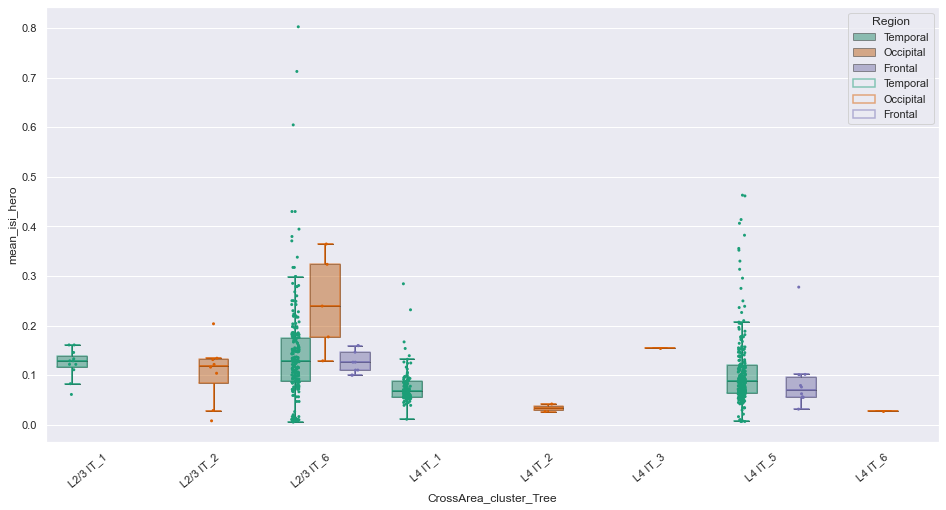

In [56]:
fig, ax1 = plt.subplots(figsize=(16,8))      # figsize=(6.5,6.5) for MSNshort2,   figsize=(4.5*26/23,6) for MSNshort1,  figsize=(7.5,7.5), figsize =(5.0,7) for IN 
sns.set(rc={'figure.figsize':(20,40)})
plot_property (df4, 'mean_isi_hero', 'Mean ISI (s)', ax1)

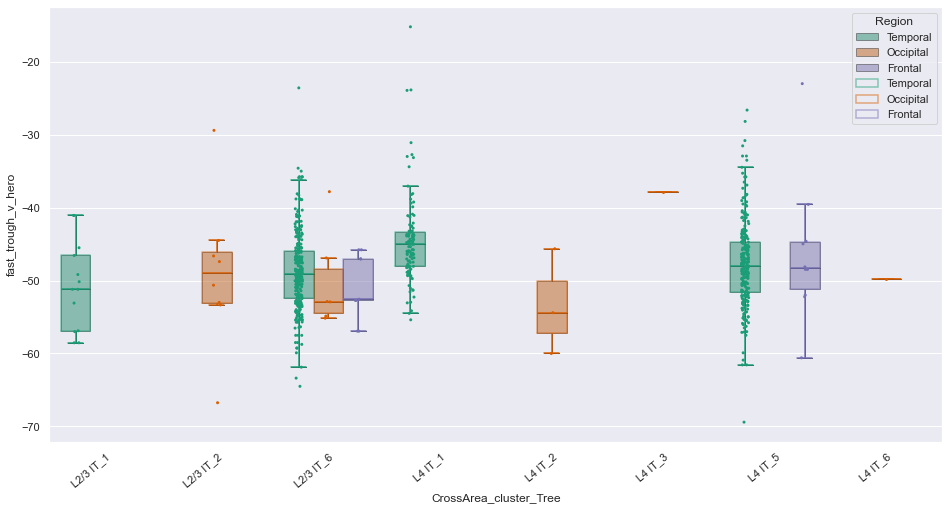

In [55]:
fig, ax1 = plt.subplots(figsize=(16,8))      # figsize=(6.5,6.5) for MSNshort2,   figsize=(4.5*26/23,6) for MSNshort1,  figsize=(7.5,7.5), figsize =(5.0,7) for IN 
sns.set(rc={'figure.figsize':(20,40)})
plot_property (df4, 'fast_trough_v_hero', 'Fast trough V (mV)', ax1)

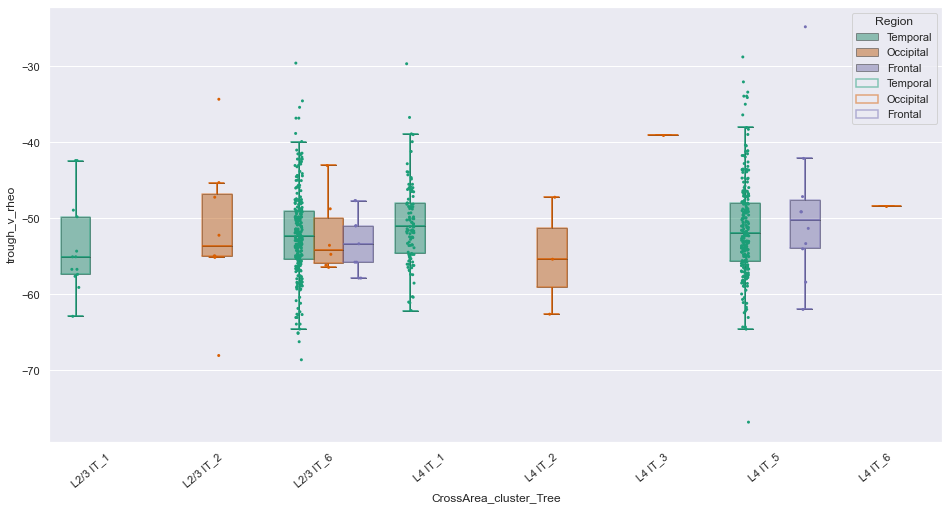

In [57]:
fig, ax1 = plt.subplots(figsize=(16,8))      # figsize=(6.5,6.5) for MSNshort2,   figsize=(4.5*26/23,6) for MSNshort1,  figsize=(7.5,7.5), figsize =(5.0,7) for IN 
sns.set(rc={'figure.figsize':(20,40)})
plot_property (df4, 'trough_v_rheo', 'Trough V (mV)', ax1)

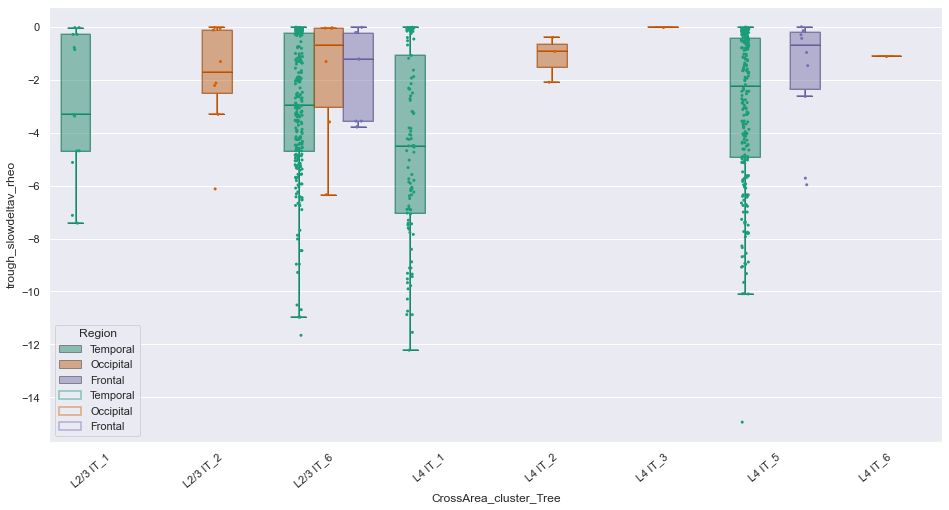

In [58]:
fig, ax1 = plt.subplots(figsize=(16,8))      # figsize=(6.5,6.5) for MSNshort2,   figsize=(4.5*26/23,6) for MSNshort1,  figsize=(7.5,7.5), figsize =(5.0,7) for IN 
sns.set(rc={'figure.figsize':(20,40)})
plot_property (df4, 'trough_slowdeltav_rheo', r'Slow AHP $\Delta$V (mV)', ax1)

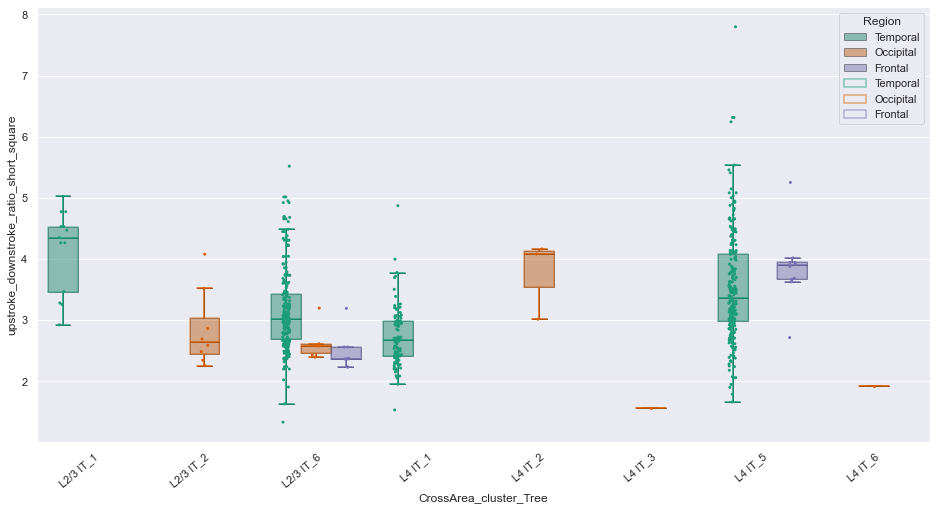

In [59]:
fig, ax1 = plt.subplots(figsize=(16,8))      # figsize=(6.5,6.5) for MSNshort2,   figsize=(4.5*26/23,6) for MSNshort1,  figsize=(7.5,7.5), figsize =(5.0,7) for IN 
sns.set(rc={'figure.figsize':(20,40)})
plot_property (df4, 'upstroke_downstroke_ratio_short_square', 'Upstroke/Downstroke', ax1)

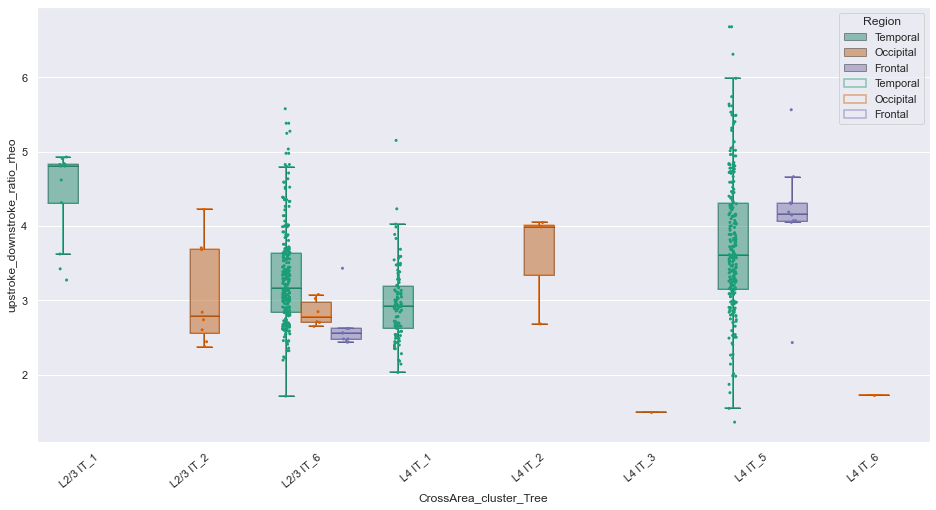

In [60]:
fig, ax1 = plt.subplots(figsize=(16,8))      # figsize=(6.5,6.5) for MSNshort2,   figsize=(4.5*26/23,6) for MSNshort1,  figsize=(7.5,7.5), figsize =(5.0,7) for IN 
sns.set(rc={'figure.figsize':(20,40)})
plot_property (df4, 'upstroke_downstroke_ratio_rheo', 'Upstroke-downstroke ratio rheo', ax1)

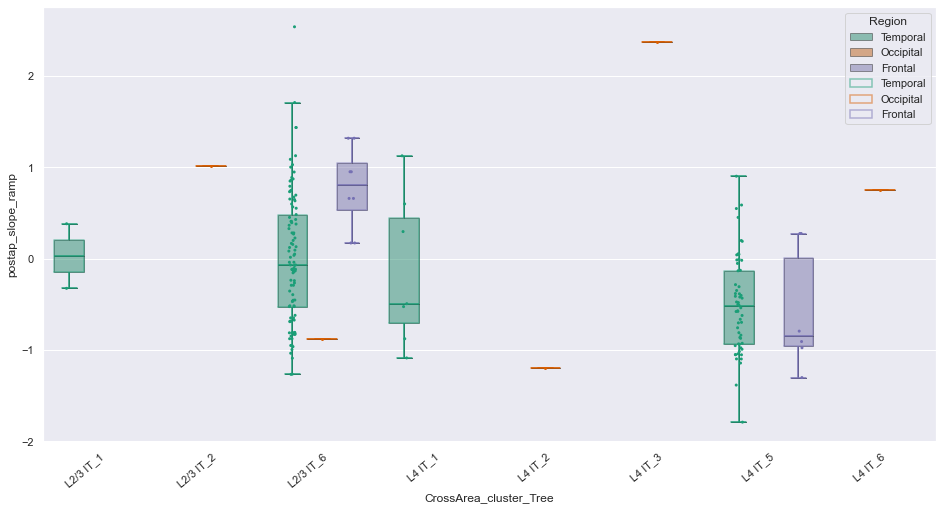

In [61]:
fig, ax1 = plt.subplots(figsize=(16,8))      # figsize=(6.5,6.5) for MSNshort2,   figsize=(4.5*26/23,6) for MSNshort1,  figsize=(7.5,7.5), figsize =(5.0,7) for IN 
sns.set(rc={'figure.figsize':(20,40)})
plot_property (df4, 'postap_slope_ramp', '', ax1)

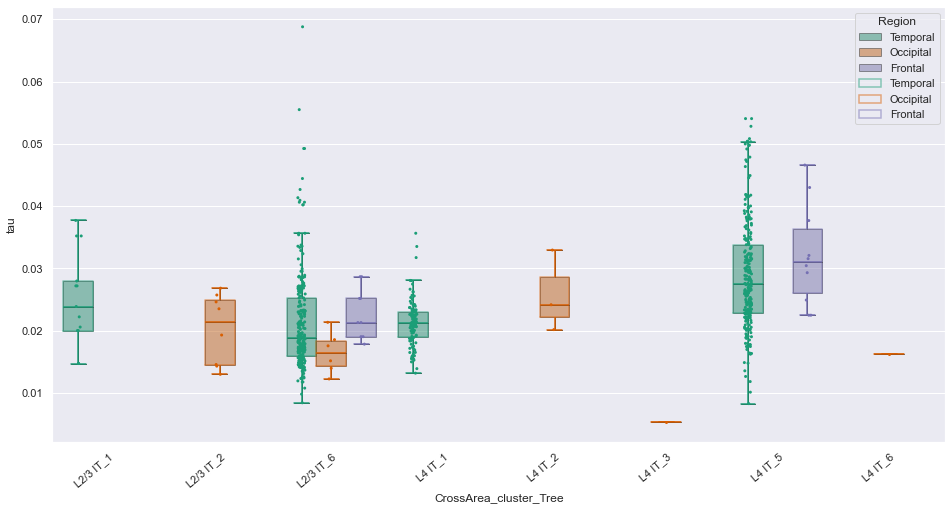

In [62]:
fig, ax1 = plt.subplots(figsize=(16,8))      # figsize=(6.5,6.5) for MSNshort2,   figsize=(4.5*26/23,6) for MSNshort1,  figsize=(7.5,7.5), figsize =(5.0,7) for IN 
sns.set(rc={'figure.figsize':(20,40)})
plot_property (df4, 'tau', r'Membrane $\tau$ (ms)', ax1)

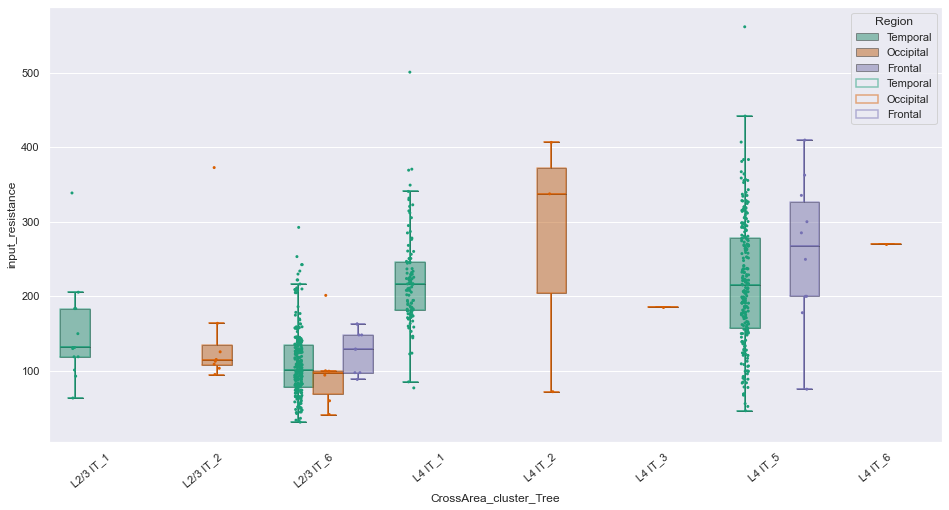

In [63]:
fig, ax1 = plt.subplots(figsize=(16,8))      # figsize=(6.5,6.5) for MSNshort2,   figsize=(4.5*26/23,6) for MSNshort1,  figsize=(7.5,7.5), figsize =(5.0,7) for IN 
sns.set(rc={'figure.figsize':(20,40)})
plot_property (df4, 'input_resistance', 'R$_{in}$ (M$\Omega$)', ax1)

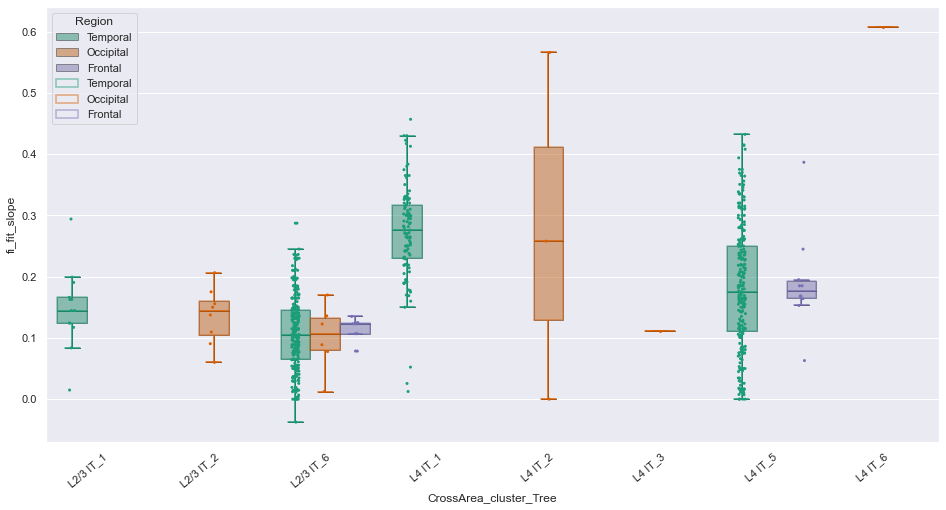

In [64]:
fig, ax1 = plt.subplots(figsize=(16,8))      # figsize=(6.5,6.5) for MSNshort2,   figsize=(4.5*26/23,6) for MSNshort1,  figsize=(7.5,7.5), figsize =(5.0,7) for IN 
sns.set(rc={'figure.figsize':(20,40)})
plot_property (df4, 'fi_fit_slope', 'F-I Slope', ax1)

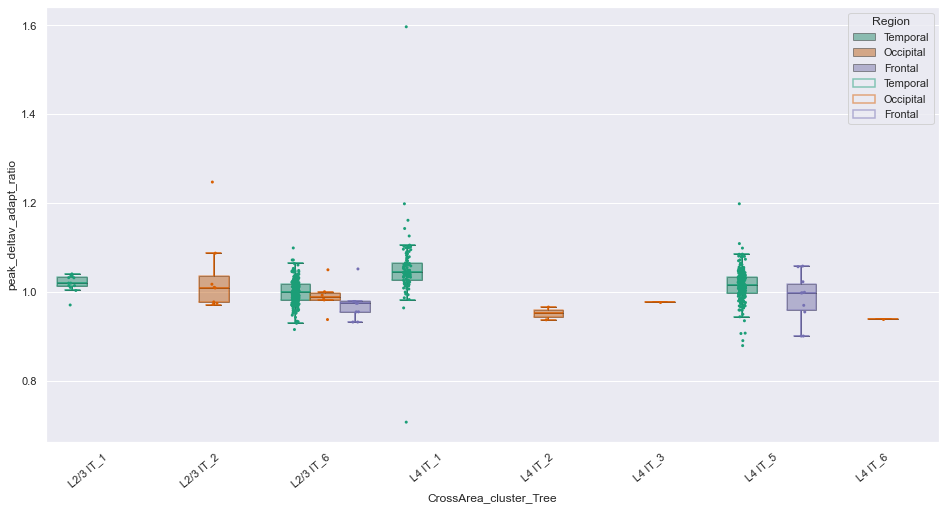

In [65]:
fig, ax1 = plt.subplots(figsize=(16,8))      # figsize=(6.5,6.5) for MSNshort2,   figsize=(4.5*26/23,6) for MSNshort1,  figsize=(7.5,7.5), figsize =(5.0,7) for IN 
sns.set(rc={'figure.figsize':(20,40)})
plot_property (df4, 'peak_deltav_adapt_ratio', 'peak_deltav_adapt_ratio', ax1)

In [ ]:
# Exploring pinned locations - concluded these are incomplete and have accuracy issues
df_pins = pd.read_excel("./Human_Exc_cortical_pinning.xlsx")

In [ ]:
df_pins[df_pins.lobe=='TemL']['structure'].value_counts()

In [ ]:
df_pins[df_pins.lobe=='OccL']['structure'].value_counts()

In [93]:
df_pins[df_pins.lobe=='FroL']['structure'].value_counts()

MFG      67
SFG      48
FroL     45
LOrG      4
IFGtr     3
PaCG      2
Name: structure, dtype: int64

In [ ]:
df_V1 = df_V1.rename(columns={'structure': 'structure_anno'})

In [ ]:
merged_V1 = pd.merge(df_pins, df_V1, how='outer', on='cell_id')
sub = merged_V1[['cell_id', 'CrossArea_subclass_Tree', 'CrossArea_subclass_Corr', 'CrossArea_cluster_Tree', 'CrossArea_cluster_Corr','cell_specimen_project','roi', 'structure', 'lobe', 'cortex_layer']]

In [ ]:
#sub = sub[sub['lobe']=='OccL']
sub = sub[sub['roi'].str.contains('VISp').fillna(False)]
sub